In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from tqdm import tqdm

In [2]:
data_folder = "data"

image_files = [f for f in os.listdir(data_folder) if f.endswith("png")]

In [3]:
# Print the resolutions of the 3 images
for image_file in image_files:
    img = Image.open(os.path.join(data_folder, image_file))
    print(f"{image_file} has resolution {img.size}")

0002.png has resolution (2040, 1848)
0010.png has resolution (2040, 1644)
0028.png has resolution (2040, 1992)


### Chose a random image to train a neural representation on

(-0.5, 2039.5, 1847.5, -0.5)

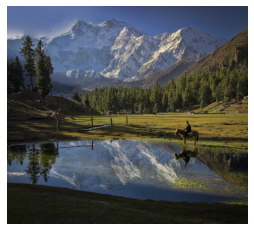

In [4]:
# Set random seed to 1
random.seed(1)

random_img_file = random.choice(image_files)
img_path = os.path.join(data_folder, random_img_file)

# load the image
img = Image.open(img_path)
# convert image to numpy array
img_np = np.array(img)
# display the image
plt.imshow(img_np)
plt.axis("off")

In [6]:
# Original resolution of the image

height, width, channels = img_np.shape
print(f"Image dimensions: {width}x{height}, {channels} channels") # r,g,b channels

Image dimensions: 2040x1848, 3 channels


In [9]:
# Maximum and mean values of the image (0-255 scale)
print(f"Maximum pixel value in the image: {img_np.max()}")
print(f"Mean value of the image: {img_np.min()}")

Maximum pixel value in the image: 255
Mean value of the image: 0


Image dimensions: 2040x1848, 3 channels


  2%|▏         | 1/50 [00:01<01:25,  1.75s/it]

Epoch 0, Loss: 0.025502


100%|██████████| 50/50 [01:24<00:00,  1.68s/it]


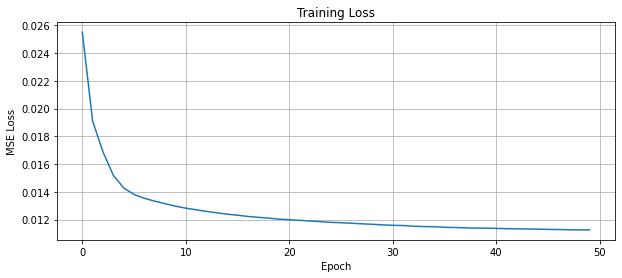

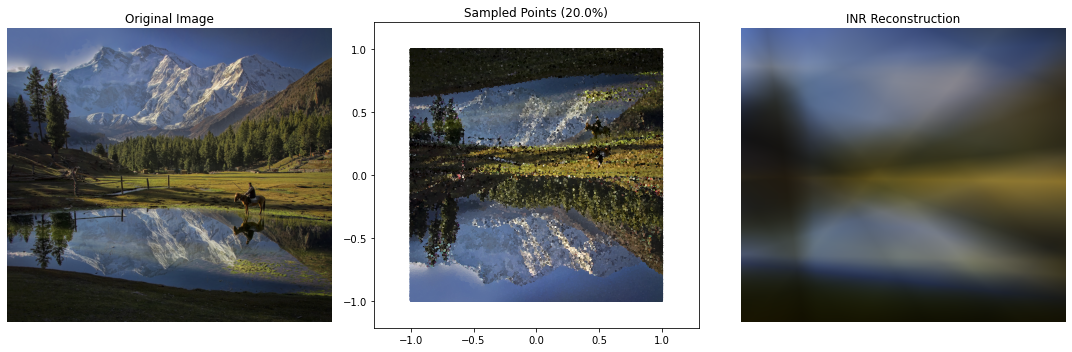

In [14]:
# Simple INR implementation (direct coordinate mapping)
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Convert image to numpy array and normalize
img_np = np.array(img).astype(np.float32) / 255.0

# Get original dimensions
height, width, channels = img_np.shape
print(f"Image dimensions: {width}x{height}, {channels} channels")

# Create coordinate grid (normalized between -1 and 1)
def get_coordinates(h, w):
    """Generate normalized coordinate grid for an image"""
    y = np.linspace(-1, 1, h)
    x = np.linspace(-1, 1, w)
    X, Y = np.meshgrid(x, y)
    coords = np.stack([X, Y], axis=-1)  # [h, w, 2]
    return coords.reshape(-1, 2)  # Flatten to [h*w, 2]

# Get all coordinates and pixel values
coords = get_coordinates(height, width)
pixels = img_np.reshape(-1, channels)

# Random downsampling - select a random subset of pixels for training
downsample_ratio = 0.2  # Use 20% of pixels for training
num_samples = int(downsample_ratio * coords.shape[0])
indices = np.random.choice(coords.shape[0], size=num_samples, replace=False)

# Get the sampled coordinates and pixel values
sampled_coords = coords[indices]
sampled_pixels = pixels[indices]

# Convert to PyTorch tensors
coords_tensor = torch.from_numpy(coords).float()
sampled_coords_tensor = torch.from_numpy(sampled_coords).float()
sampled_pixels_tensor = torch.from_numpy(sampled_pixels).float()

# Define a simple MLP for the INR
class SimpleINR(nn.Module):
    def __init__(self, input_dim=2, output_dim=3, hidden_dim=256, num_layers=2):
        super().__init__()
        
        layers = []
        # First layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())  # Ensure output is in [0, 1] range
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Create and train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleINR(input_dim=2, output_dim=channels, hidden_dim=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Move data to device
sampled_coords_tensor = sampled_coords_tensor.to(device)
sampled_pixels_tensor = sampled_pixels_tensor.to(device)

# Training loop
num_epochs = 50
batch_size = 4096
losses = []

for epoch in tqdm(range(num_epochs)):
    # Create random batches
    perm = torch.randperm(sampled_coords_tensor.shape[0])
    total_loss = 0
    
    for i in range(0, sampled_coords_tensor.shape[0], batch_size):
        indices = perm[i:i+batch_size]
        batch_coords = sampled_coords_tensor[indices]
        batch_pixels = sampled_pixels_tensor[indices]
        
        # Forward pass
        pred_pixels = model(batch_coords)
        
        # Compute loss
        loss = criterion(pred_pixels, batch_pixels)
        total_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / (sampled_coords_tensor.shape[0] // batch_size + 1)
    losses.append(avg_loss)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

# Plot the loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

# Render the full image using the trained model
with torch.no_grad():
    coords_device = coords_tensor.to(device)
    # Process in batches to avoid memory issues
    pred_pixels = []
    for i in range(0, coords_device.shape[0], batch_size):
        batch_coords = coords_device[i:i+batch_size]
        batch_pred = model(batch_coords).cpu().numpy()
        pred_pixels.append(batch_pred)
    
    pred_pixels = np.vstack(pred_pixels)
    pred_img = pred_pixels.reshape(height, width, channels)

# Display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.scatter(sampled_coords[:, 0], sampled_coords[:, 1], s=1, c=sampled_pixels)
plt.title(f'Sampled Points ({downsample_ratio*100:.1f}%)')
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.imshow(pred_img)
plt.title('INR Reconstruction')
plt.axis('off')

plt.tight_layout()
plt.show()